## Customer clustering - ML project
Author: Andrii Zapukhlyi

### Project description

I have a dataset with customer data of a certain store with customerID, gender, age, annual income and defined spending score, which ranges from 0 to 100. <br>
My goal is to clean the data, visualize it and make customer segmentation with unsupervised Machine Learning algorithms

### Import libraries and dataset

In [1613]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.metrics import silhouette_score

In [1614]:
df = pd.read_csv("customers.csv")
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


## Data preprocessing

In [1615]:
df.drop("CustomerID", axis = 1, inplace=True)
df.columns = ["gender", "age", "income", "spending_score"]

I deleted the customerID column, because it has no impact on other data.

In [1616]:
df.describe()

,age,income,spending_score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


There are 3 numerical columns in the dataset with 200 rows. <br>
- Age of customer in range (18; 70), where mean age equals 39
- Annual income in thousands of dollars in range(15;137), where mean equals 65,600$
- Spending score with mean equals 50,2 

In [1617]:
df.gender.unique()

array(['Male', 'Female'], dtype=object)

As we can see, there are two genders in our dataset: "Male" and "Female"

In [1618]:
df.isnull().sum()

gender            0
age               0
income            0
spending_score    0
dtype: int64

In [1619]:
df.duplicated().sum()

0

There aren't neither null values nor duplicated rows

In [1620]:
numerical = df.select_dtypes(["int", "float"]).columns

Created a list with titles of numerical columns to check them on outliers. <br>
I will define the boxplots() function to plot boxplots with each numerical variable in the dataset

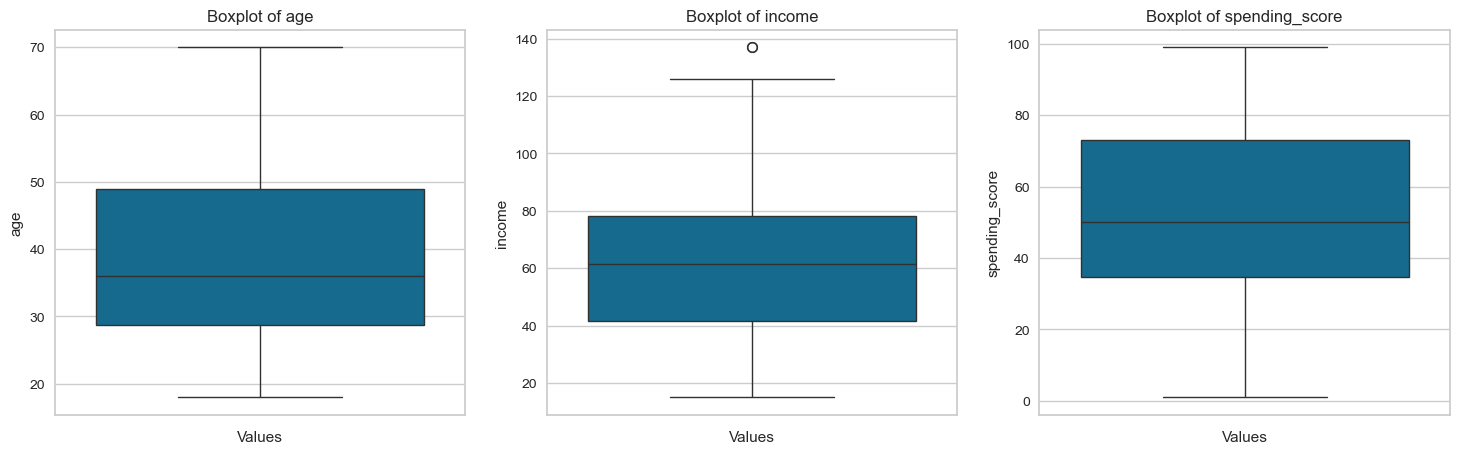

In [1621]:
def boxplots(df):
    fig, axes = plt.subplots(nrows=1, ncols=len(numerical), figsize=(18,5))
    for i, col in enumerate(numerical):
        sns.boxplot(y=col, data=df, ax=axes[i])
        axes[i].set_ylabel(col)
        axes[i].set_xlabel('Values')
        axes[i].set_title(f'Boxplot of {col}')
    plt.show()
boxplots(df)

From the chart above, we can see that there is an outlier in the income column, where annual income is bigger than 130,000$. <br>
Let's remove it with the IQR method

In [1622]:
Q1 = np.quantile(df.income, 0.25)
Q3 = np.quantile(df.income, 0.75)
IQR = Q3 - Q1
lower_lim = Q1-1.5*IQR
upper_lim = Q3+1.5*IQR

In [1623]:
df = df[(df['income'] > lower_lim) & (df['income'] < upper_lim)]

I calculated the first and third quartiles with numpy library, then determined the IQR and lower/upper limit values.
All values less than lower limit or bigger than upper limit are outliers, so I removed them.

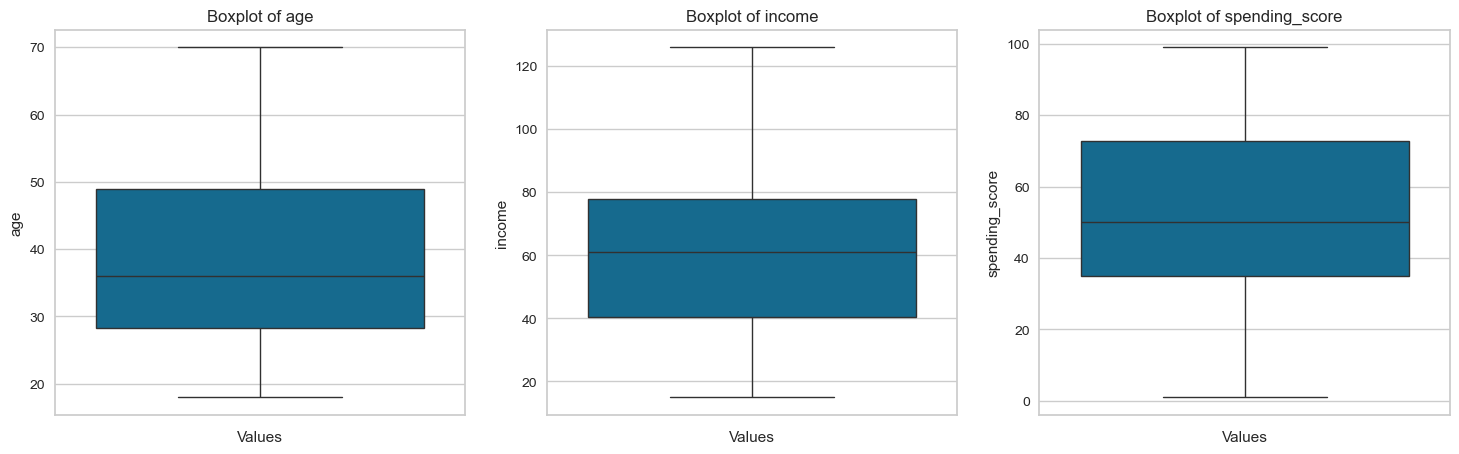

In [1624]:
boxplots(df)

There aren't any outliers in our dataset now

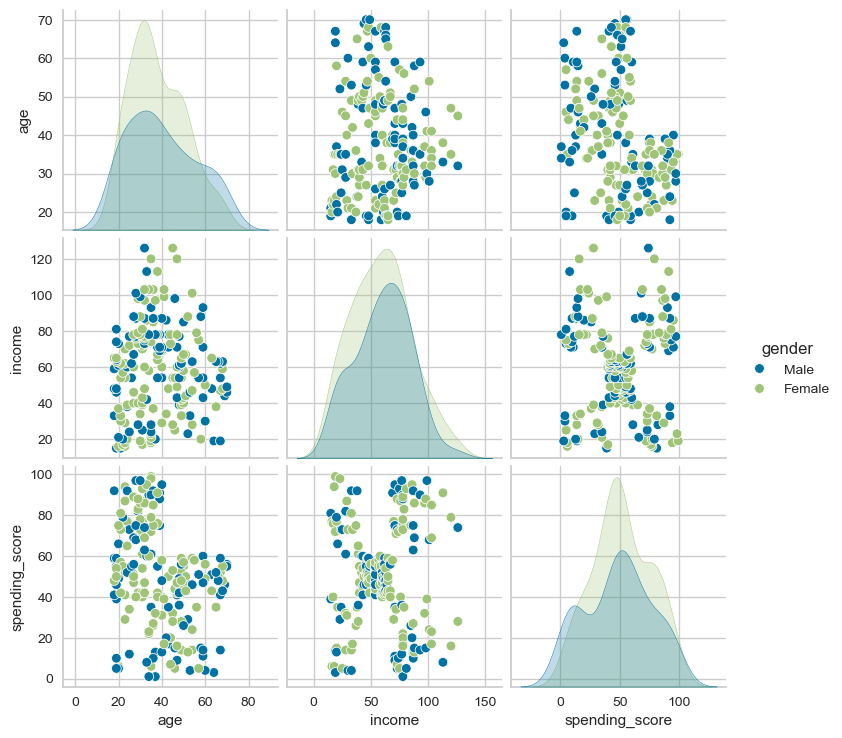

In [1625]:
sns.pairplot(df, hue = 'gender')
plt.show()

From the chart above with relationships between variables in the dataset, we can see, that gender has no direct relation to segmenting customers, so I will remove it.

In [1626]:
df.drop("gender", axis=1, inplace=True)

## K-means Clustering

I used the Elbow method to choose the appropriate number of clusters using K-means clustering with different K and calculating the sum squared errors for each

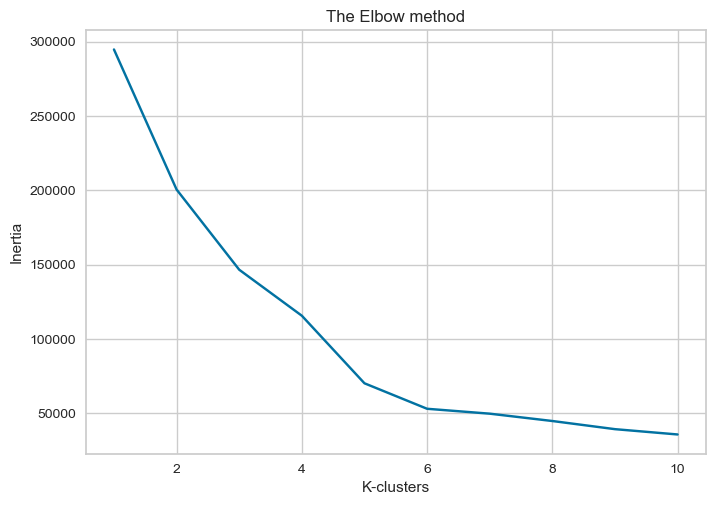

In [1627]:
sse = []
for i in range(1,11):
    km = KMeans(n_clusters = i, random_state=22)
    km.fit(df)
    sse.append(km.inertia_)

plt.plot(range(1,11), sse)
plt.xlabel("K-clusters")
plt.ylabel("Inertia")
plt.title("The Elbow method")
plt.show()

From the chart, we can note, that 5 clusters will be great for the dataset. <br>
Also, we can use KElbowVisualizer() function from yellowbrick library to validate this. 

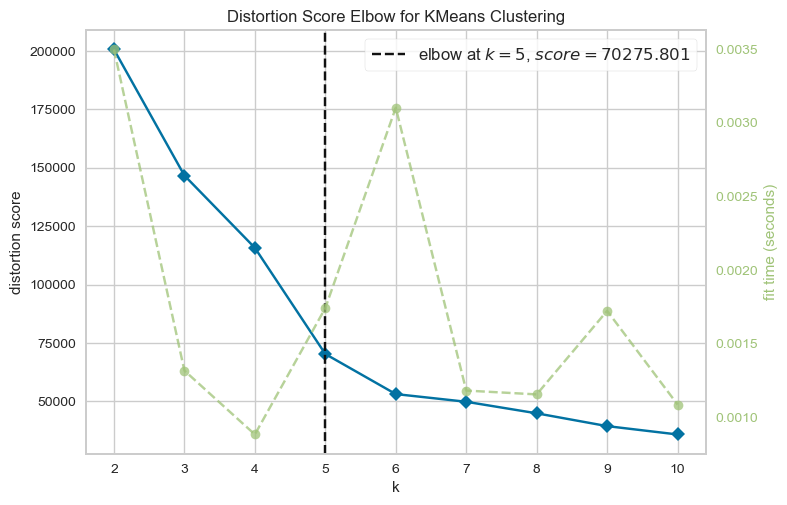

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [1628]:

Elbow_M = KElbowVisualizer(KMeans(random_state=22), k=10)
Elbow_M.fit(df)
Elbow_M.show()

I built a KMeans model to cluster the dataset into 5 groups. Then, I plotted a scatter plot using income and spending scores, with each cluster represented by a different color.

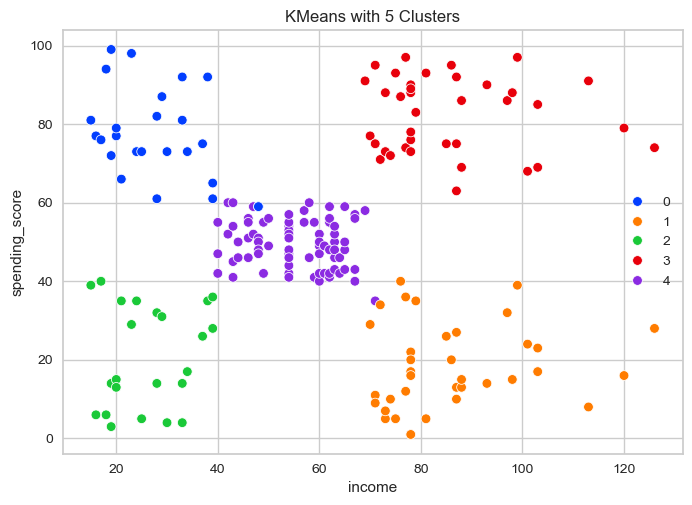

In [1629]:
km5 = KMeans(n_clusters = 5, random_state=22)
km5.fit(df)
sns.scatterplot(x=df.income, y=df.spending_score, hue = km5.labels_, palette=sns.color_palette("bright", 5))
plt.title('KMeans with 5 Clusters')
plt.show()

Income vs spending score plot shows the clusters pattern:
- group 0: low income but high spending score
- group 1: high income but low spending score
- group 2: low income and low spending score
- group 3: high income and high spending score
- group 4: medium income and medium spending score

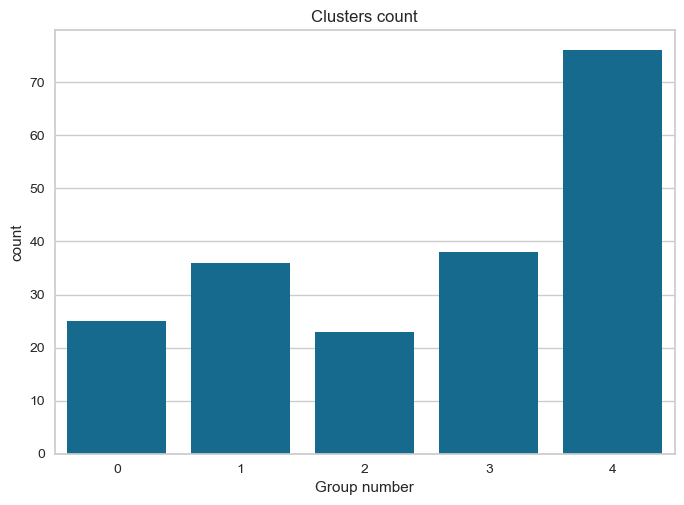

In [1630]:
sns.countplot(x = km5.labels_)
plt.title("Clusters count")
plt.xlabel("Group number")
plt.show()

From the above chart, we can observe, that group 4 (medium income and medium spending score) is the biggest. Other groups have a similar amount of observation

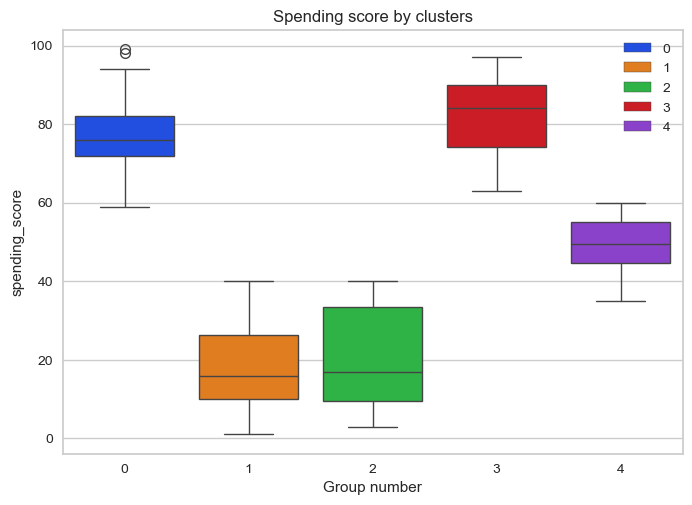

In [1631]:
sns.boxplot(x = km5.labels_, y=df.spending_score, hue = km5.labels_, palette=sns.color_palette("bright", 5))
plt.title("Spending score by clusters")
plt.xlabel("Group number")
plt.show()

The plot shows main statistics of a clusters:
- groups 1 and 2 have spending score between 0 and 40 with median near 15
- group 4 has spending score between 35 and 60 with median 50 points
- group 0 and 3 have spending score bigger than 58 with median 75 for group 0 and median 85 for group 3 

## Hierarchical clustering
Additionally, I will perform segmentation using the Agglomerative Clustering algorithm to examine how the dataset is represented hierarchically <br>
To choose the optimal number of clusters for hierarchical clustering I'll plot the dendrogram of the data

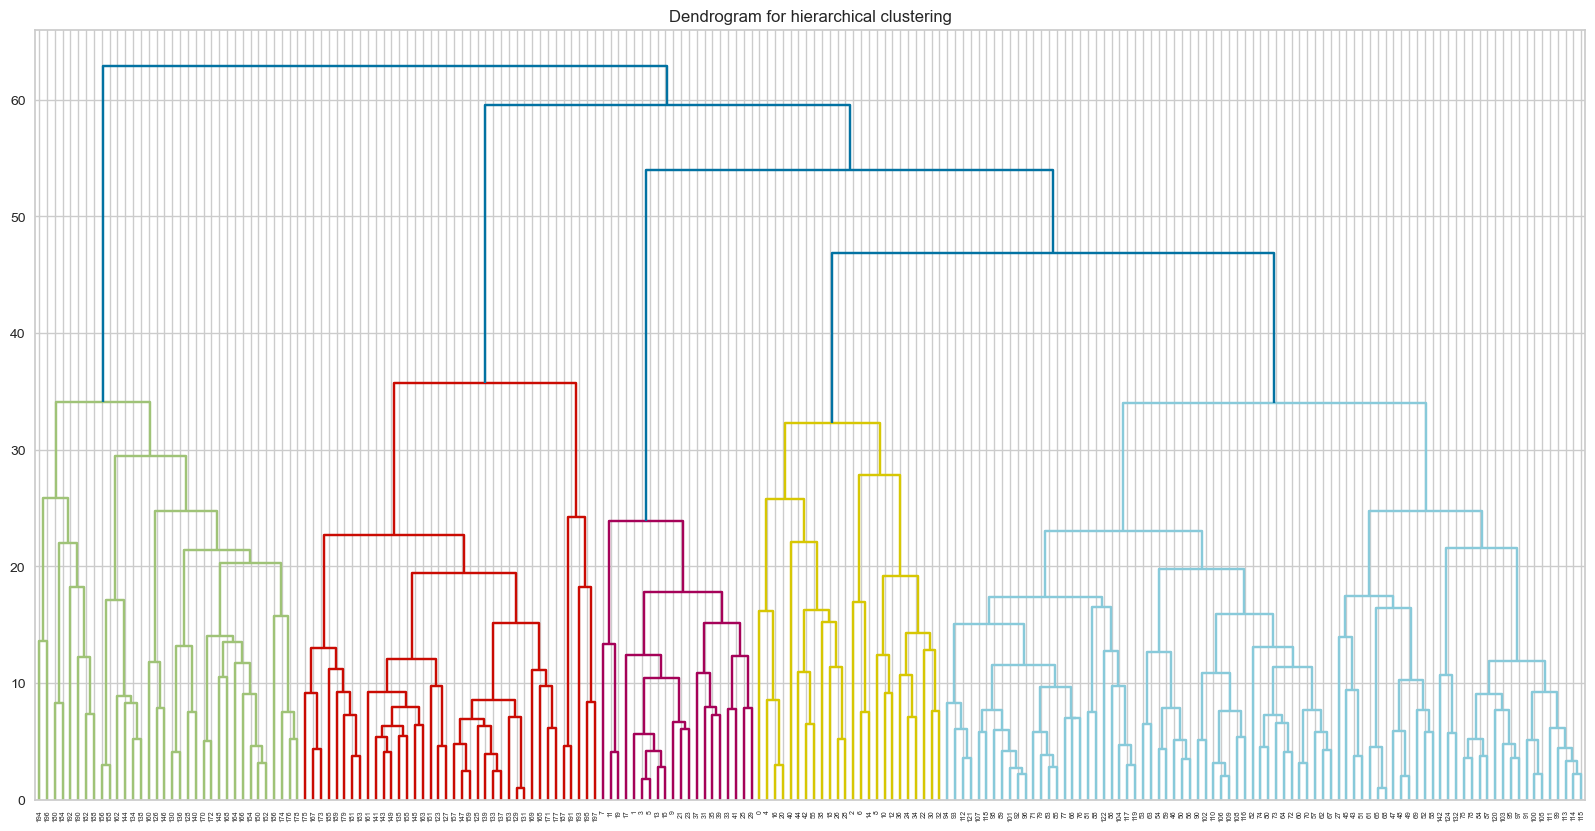

In [1632]:
plt.figure(figsize=(20, 10))
plt.title("Dendrogram for hierarchical clustering")
dend = shc.dendrogram(shc.linkage(df, method='average'))
plt.show()

The dendrogram indicates that dividing the dataset into 5 clusters would be appropriate

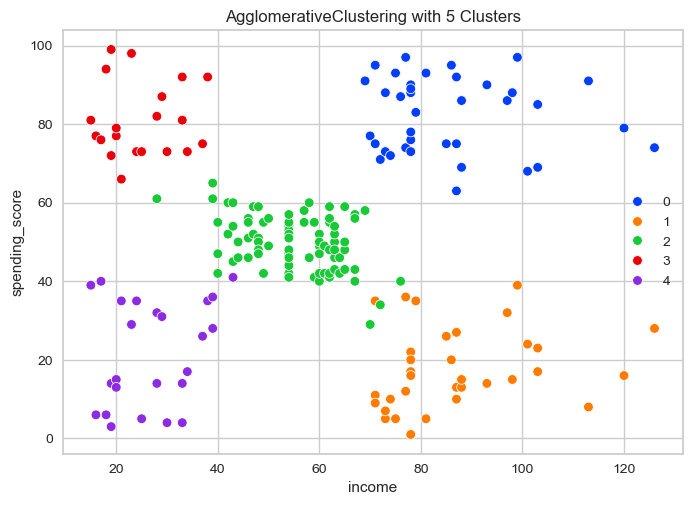

In [1633]:
ac = AgglomerativeClustering(n_clusters=5, linkage='average').fit(df)
sns.scatterplot(x=df.income, y=df.spending_score, hue = ac.labels_, palette=sns.color_palette("bright", 5))
plt.title('AgglomerativeClustering with 5 Clusters')
plt.show()

The result so similar to KMeans algorithm 

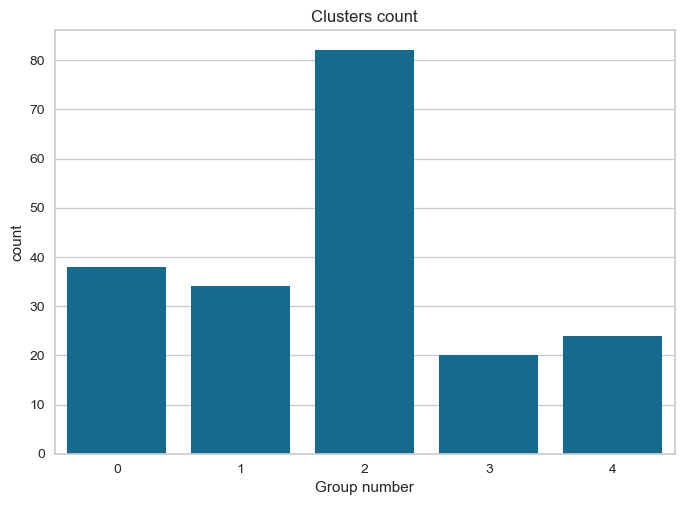

In [1634]:
sns.countplot(x = ac.labels_)
plt.title("Clusters count")
plt.xlabel("Group number")
plt.show()

In the AgglomerativeClustering algorithm group 2 represents medium income and medium spending score and it has the most observations

#### Silhouette score
```
The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters. 
The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
```

I'll calculate it for the clustering algorithms

In [1635]:
print(silhouette_score(df, km5.labels_), silhouette_score(df, ac.labels_))

0.4445382944697605 0.4395033644071675


Both models have a score of 0.44, indicating a good clustering result

## Conclusion

I applied clustering techniques to segment our dataset into distinct groups. <br>
Used both KMeans and Agglomerative Clustering algorithms to identify natural groupings within the data in different ways. <br> 
After evaluating the performance of these models using charts and the silhouette score, both models indicate a good clustering result.

## Thanks for reading!